## **LSTM Grid Search for Crypto Lending and Borrowing Rates**

**1. Performing Grid Search on Feature Importance:** We perform a grid search on the base architecture of the LSTM model, experimenting with different combinations of input features to determine their importance. We store the results of each combination in a DataFrame and save them to CSV files.

**2. Performing Grid Search on Outlier Importance:** We experiment with different outlier thresholds to understand their impact on the model's performance. We filter the data based on these thresholds and evaluate the model's performance.

**3. Performing Grid Search on Loss Functions:** We experiment with different loss functions and class weights to handle class imbalance. We evaluate the model's performance using various metrics such as accuracy, precision, recall, and F1 score.

**4. Performing Grid Search on Input and Output Windows:** We experiment with different combinations of input and output windows to determine the optimal window sizes for the LSTM model. We evaluate the model's performance and store the results in a DataFrame.

**5. Analyzing Results:** We concatenate the results from the various grid searches and save them to CSV files. We also analyze the results to identify the best-performing combinations of input features, outlier thresholds, loss functions, and input/output windows for predicting crypto lending and borrowing rates using the LSTM model.

**6. Conclusion:** The notebook concludes with the analysis of the grid search results, providing insights into the best-performing configurations for the LSTM model. This includes the optimal input features, outlier thresholds, loss functions, and input/output windows for accurate predictions.

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import utils as pre
import warnings
warnings.filterwarnings('ignore')

In [2]:
connection = pre.connect_to_database()
if connection:
    # Query merged data
    merged_df = pre.query_merged_crypto_data(connection)
    # converting US bond yield from hourly to yearly under continous compounding assumptions
    merged_df['yield'] = np.exp(merged_df['yield']*365*24)-1

    # Close the connection
    pre.query_quit(connection)

merged_df.head(3)

Connected to MySQL database, MySQL Server version:  8.0.39
MySQL connection is closed


,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,market_cap,coin_supply,yield
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,None,0.008552840317602313182744400
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,None,0.008552840317602313182744400
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,None,0.008552840317602313182744400


### merging with market cap

In [3]:
market_caps = pd.read_csv('market_cap_data.csv')
market_caps = market_caps.rename(columns={
    'timestamp': 'date',
    'token': 'crypto_symbol',
})
market_caps.head(3)

,Unnamed: 0,date,market_cap,crypto_symbol
0,0,2020-12-21 00:00:00,87121414,1INCHUSDT
1,1,2020-12-21 01:00:00,87121414,1INCHUSDT
2,2,2020-12-21 02:00:00,87121414,1INCHUSDT


In [4]:
# Convert 'date' columns to pandas datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])
market_caps['date'] = pd.to_datetime(market_caps['date'])

# Perform the merge based on 'crypto_symbol' and 'date', keeping only rows in merged_df
merged_df.drop('market_cap', axis = 1, inplace=True)
merged_df = pd.merge(
    merged_df,
    market_caps[['date', 'market_cap', 'crypto_symbol']],
    on=['date', 'crypto_symbol'],
    how='left'
)

merged_df.head(3)

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,coin_supply,yield,market_cap
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,0.008552840317602313182744400,317700843.0
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,0.008552840317602313182744400,317700843.0
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,0.008552840317602313182744400,317700843.0


In [8]:
# KNC has wrong data before 2021
merged_df = merged_df[merged_df['market_cap'].notna()]
merged_df.reset_index(inplace = True, drop=True)

In [9]:
merged_df_emb = pre.create_llm_embeddings(merged_df, "crypto_symbol", n_components=15)
merged_df_emb = pre.create_cyclical_encodings(merged_df_emb, "date")

In [10]:
merged_df_emb.columns

Index(['lending_rate', 'borrowing_rate', 'utilization_rate',
       'stable_borrow_rate', 'crypto_symbol', 'date', 'high', 'low', 'close',
       'adj_close', 'volume', 'coin_supply', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine'],
      dtype='object')

In [11]:
# data without NA rows if we needed 
filtered_df = merged_df_emb[(merged_df['borrowing_rate'] != -50)&(merged_df['lending_rate'] != -50)&(merged_df['utilization_rate'] != -50)]
filtered_df['attention'] = filtered_df['volume'] * filtered_df['close']
filtered_df.drop(columns=['stable_borrow_rate','adj_close','coin_supply'], inplace=True)
filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']] = filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']].astype(float)
# removing wbtc because of its small amuont of data in 2024
filtered_df = filtered_df[filtered_df['crypto_symbol'] != 'WBTCUSDT']
filtered_df.reset_index(inplace=True, drop=True)
print(len(filtered_df))
filtered_df.columns

401976


Index(['lending_rate', 'borrowing_rate', 'utilization_rate', 'crypto_symbol',
       'date', 'high', 'low', 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention'],
      dtype='object')

In [12]:
# We scale  market cap, attention, yield together as they are comparable
scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)
filtered_df['yield'] = scaler.fit_transform(filtered_df[['yield']])
filtered_df['market_cap'] = scaler.fit_transform(filtered_df[['market_cap']])
filtered_df['attention'] = scaler.fit_transform(filtered_df[['attention']])

### Performing Grid-search on the base arcitecture, for feature importance

In [13]:
# worse results
comb_1 = ['lending_rate', 'borrowing_rate', 'utilization_rate',
                 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention','returns']
comb_2 = ['close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention','returns']
comb_3 = ['lending_rate', 'borrowing_rate', 'utilization_rate',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine']
comb_4 = ['lending_rate', 'borrowing_rate', 'utilization_rate',
                 'close', 'volume',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention','returns']
comb_5 = ['lending_rate', 'borrowing_rate', 'utilization_rate',
                 'close', 'volume', 'yield', 'market_cap',
                   'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention','returns']
comb_6 = ['lending_rate', 'borrowing_rate', 'utilization_rate',
                 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'attention','returns']
comb_7 = ['borrowing_rate', 'utilization_rate',
                 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention','returns']
comb_8 = ['lending_rate', 'utilization_rate',
                 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention','returns']

In [14]:
outlier_threshold = 'remove'
input_window = 48
output_window = 48
epoch_num = 40
bacth_size = 100
d1 = 0.1
d2 = 0.05
cell_size = 80
input_columns_list = [comb_1, comb_2, comb_3, comb_4, comb_5, comb_6, comb_7, comb_8]

preprocessing...
length of train, valid, test: 
(83634, 48, 32)
(42245, 48, 32)
(42862, 48, 32)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 32)]          0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            36160     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 48, 80)            0         
                                                                 
 lstm_1 (LSTM)               (None, 40)                19360     
                                                                 
 batch_normalization_1 (Bat  (N

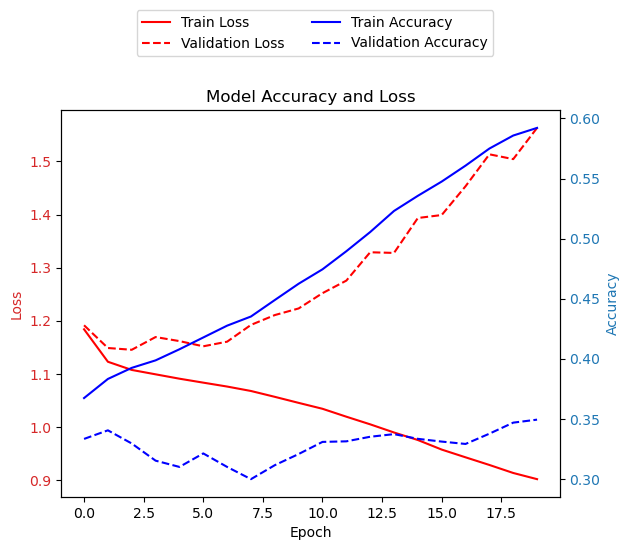

1340/1340 [==============================] - 11s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2', 'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4', 'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6', 'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8', 'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10', 'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12', 'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14', 'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine', 'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine', 'DayofWeek_Cosine', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.32683962484251783, 'precision': 0.31475074282618665, 'recall': 0.31650514794869583, 'f1': 0.27232664566660403}
preprocessing...
lengt

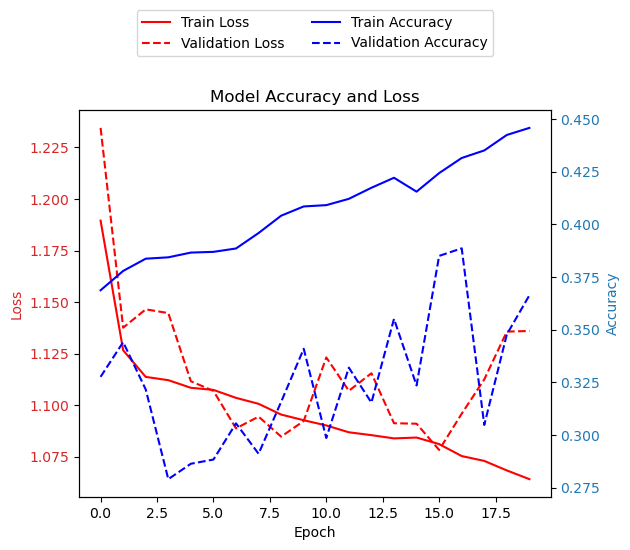

1340/1340 [==============================] - 11s 8ms/step
{'columns': "['close', 'volume', 'yield', 'market_cap', 'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2', 'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4', 'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6', 'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8', 'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10', 'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12', 'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14', 'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine', 'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine', 'DayofWeek_Cosine', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.4027810181512762, 'precision': 0.3331221634282291, 'recall': 0.3306499614146603, 'f1': 0.32091581934675134}
preprocessing...
length of train, valid, test: 
(83634, 48, 26)
(42245, 48, 26)

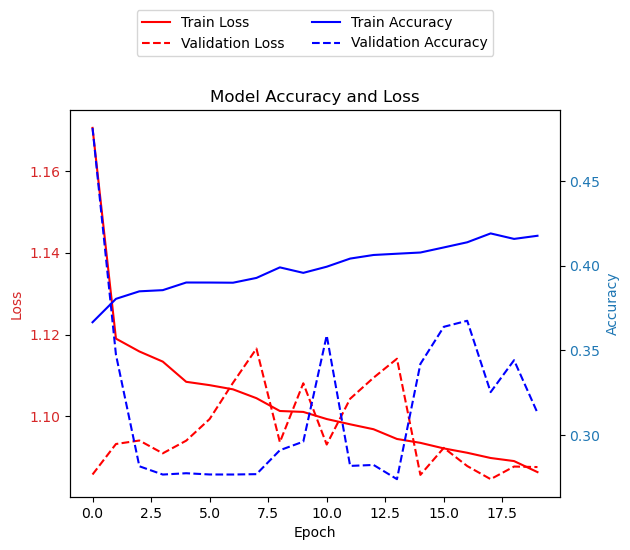

1340/1340 [==============================] - 11s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2', 'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4', 'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6', 'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8', 'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10', 'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12', 'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14', 'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine', 'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine', 'DayofWeek_Cosine']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.2706826559656572, 'precision': 0.3432597815046314, 'recall': 0.32173741876484824, 'f1': 0.21209042751413829}
preprocessing...
length of train, valid, test: 
(83634, 48, 30)
(42245, 48, 30)
(42862, 48

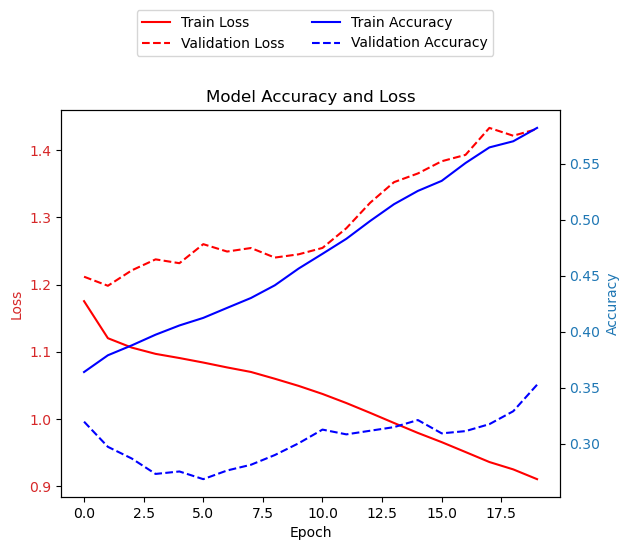

1340/1340 [==============================] - 12s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2', 'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4', 'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6', 'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8', 'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10', 'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12', 'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14', 'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine', 'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine', 'DayofWeek_Cosine', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.347183985814941, 'precision': 0.3430067134810215, 'recall': 0.3508601153338877, 'f1': 0.30452084665244733}
preprocessing...
length of train, valid, test: 
(

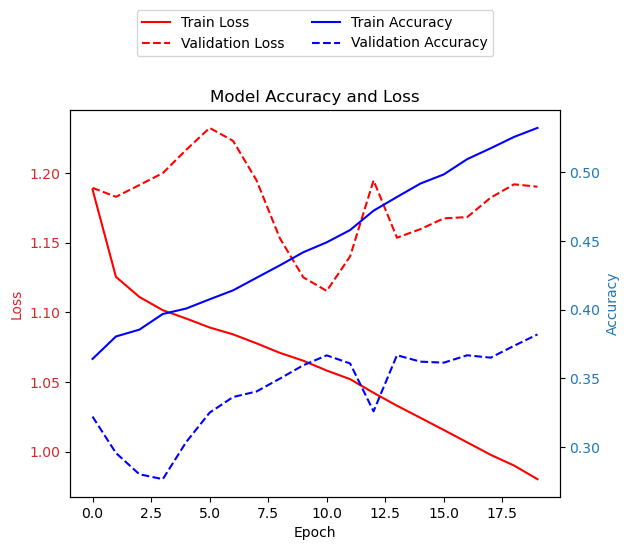

1340/1340 [==============================] - 12s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'Month_Sine', 'Month_Cosine', 'Day_Sine', 'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine', 'DayofWeek_Cosine', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.4298212869208156, 'precision': 0.36697173548533607, 'recall': 0.36222387783927346, 'f1': 0.34996443397003046}
preprocessing...
length of train, valid, test: 
(83634, 48, 24)
(42245, 48, 24)
(42862, 48, 24)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 24)]          0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            33600     
                       

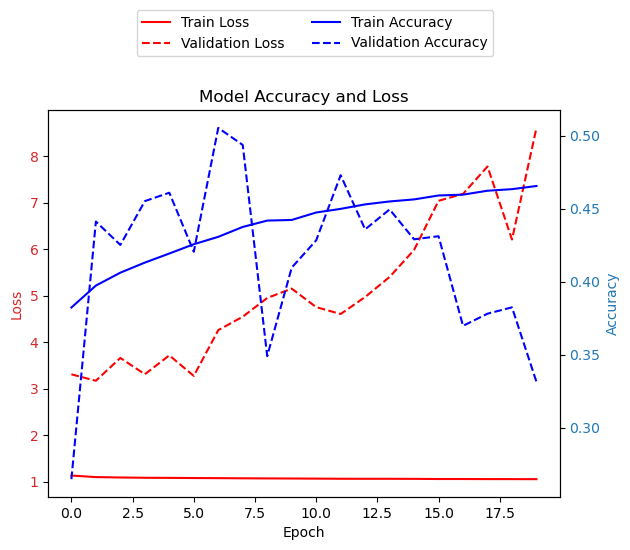

1340/1340 [==============================] - 11s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2', 'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4', 'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6', 'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8', 'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10', 'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12', 'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14', 'crypto_symbol_embedding_15', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.4155195744482292, 'precision': 0.33316074672935647, 'recall': 0.3330128239033155, 'f1': 0.31186015402539374}
preprocessing...
length of train, valid, test: 
(83634, 48, 31)
(42245, 48, 31)
(42862, 48, 31)
Model: "model"
___________________________________

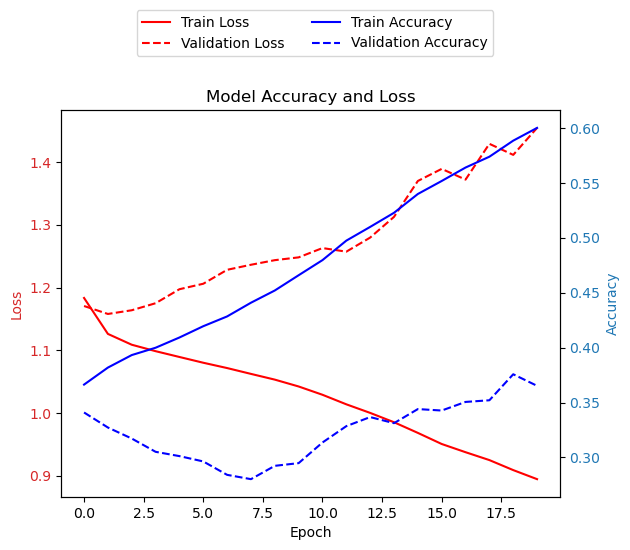

1340/1340 [==============================] - 11s 8ms/step
{'columns': "['borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2', 'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4', 'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6', 'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8', 'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10', 'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12', 'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14', 'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine', 'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine', 'DayofWeek_Cosine', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.3542065232606971, 'precision': 0.3345738147391981, 'recall': 0.33617140110701804, 'f1': 0.2969064735539814}
preprocessing...
length of train, valid, 

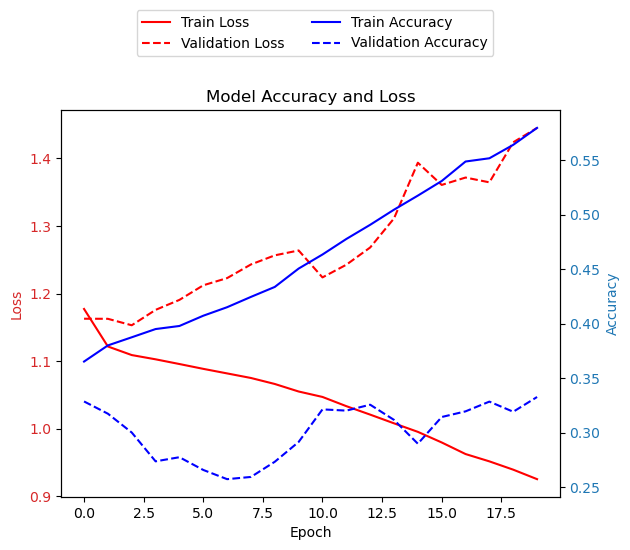

1340/1340 [==============================] - 11s 8ms/step
{'columns': "['lending_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2', 'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4', 'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6', 'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8', 'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10', 'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12', 'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14', 'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine', 'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine', 'DayofWeek_Cosine', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.36500863235499975, 'precision': 0.3478564924993817, 'recall': 0.3382923209568665, 'f1': 0.3023962178164415}


In [72]:
# Just trying a different test train percentage, and also combinations of columns
results_arr = []
for input_columns in input_columns_list: 
    try:
        print('preprocessing...')
        input_window = input_window #***
        output_window = output_window #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                    
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-09-01 00:00:00", valid_end_date="2024-03-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)

        Y_test, y_pred = pre.train_v2(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True)
        
        accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

        total_windows = Y_test.shape[0]
            
        new_row = {
            'columns': f'{input_columns}',
            'total_windows':total_windows,
            'input_window':input_window,
            'output_window':output_window, 
            'outlier_threshold':outlier_threshold, 
            'accuracy':accuracy, 
            'precision':precision, 
            'recall':recall, 
            'f1':f1
        }
        results_arr.append(new_row)
        print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr)

In [73]:
results.to_csv('results_feature_importance_v3.csv')

In [74]:
results

,columns,total_windows,input_window,output_window,outlier_threshold,accuracy,precision,recall,f1
0,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.326840,0.314751,0.316505,0.272327
1,"['close', 'volume', 'yield', 'market_cap', 'cr...",42862,48,48,remove,0.402781,0.333122,0.330650,0.320916
2,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.270683,0.343260,0.321737,0.212090
3,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.347184,0.343007,0.350860,0.304521
4,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.429821,0.366972,0.362224,0.349964
5,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.415520,0.333161,0.333013,0.311860
6,"['borrowing_rate', 'utilization_rate', 'close'...",42862,48,48,remove,0.354207,0.334574,0.336171,0.296906
7,"['lending_rate', 'utilization_rate', 'close', ...",42862,48,48,remove,0.365009,0.347856,0.338292,0.302396



### Trying balance data set

preprocessing...
length of train, valid, test: 
(101157, 48, 32)
(24722, 48, 32)
(42862, 48, 32)
affter balancing distribution:
(70785, 48, 32)
borrow_rate_Y_train: [23595 23595 23595]
borrow_rate_Y_valid: [13179  6284  5259]
borrow_rate_Y_test: [25065  9328  8469]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 32)]          0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            36160     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 48, 80)            0         
                                                           

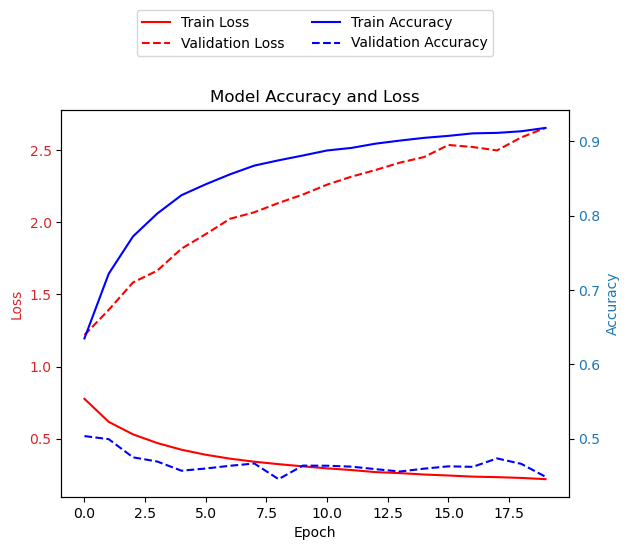

1340/1340 [==============================] - 11s 8ms/step


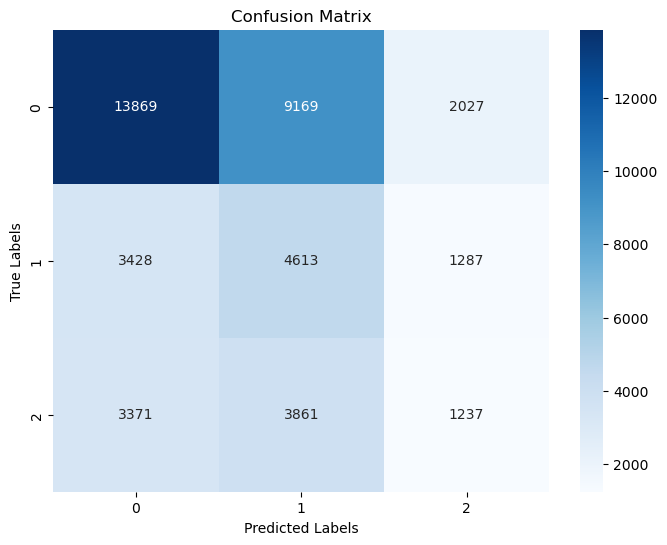

Classification Metrics:
Accuracy: 0.46
Precision: 0.40
Recall: 0.40
F1 Score: 0.38

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.55      0.61     25065
           1       0.26      0.49      0.34      9328
           2       0.27      0.15      0.19      8469

    accuracy                           0.46     42862
   macro avg       0.40      0.40      0.38     42862
weighted avg       0.50      0.46      0.47     42862

{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2', 'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4', 'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6', 'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8', 'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10', 'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12', 'crypto_symbol_embedding_13', 'crypto_symb

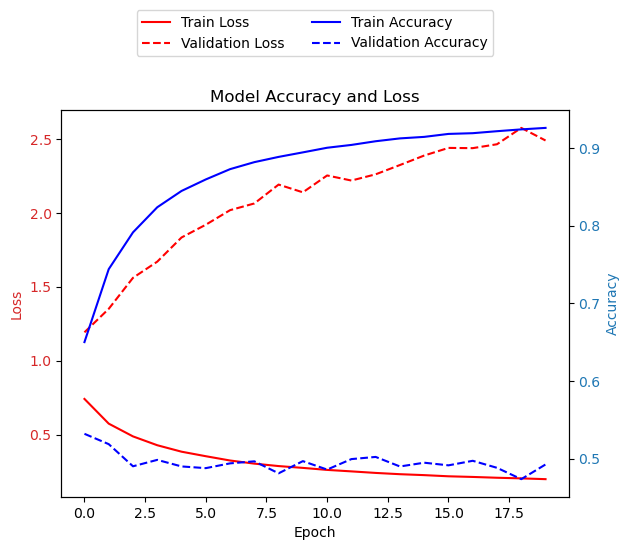

1340/1340 [==============================] - 12s 8ms/step


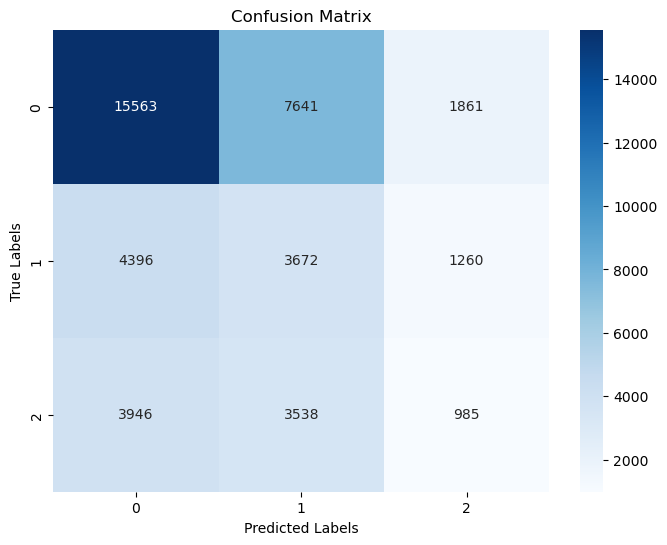

Classification Metrics:
Accuracy: 0.47
Precision: 0.38
Recall: 0.38
F1 Score: 0.37

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.62      0.64     25065
           1       0.25      0.39      0.30      9328
           2       0.24      0.12      0.16      8469

    accuracy                           0.47     42862
   macro avg       0.38      0.38      0.37     42862
weighted avg       0.48      0.47      0.47     42862

{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2', 'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4', 'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6', 'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8', 'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10', 'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12', 'crypto_symbol_embedding_13', 'crypto_symb

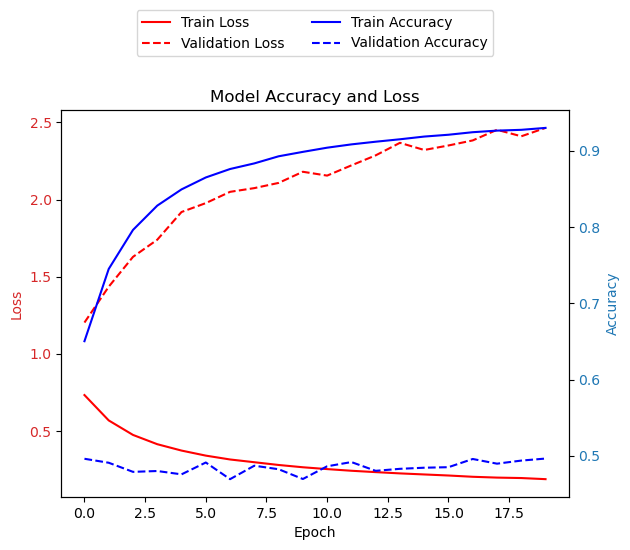

1340/1340 [==============================] - 12s 8ms/step


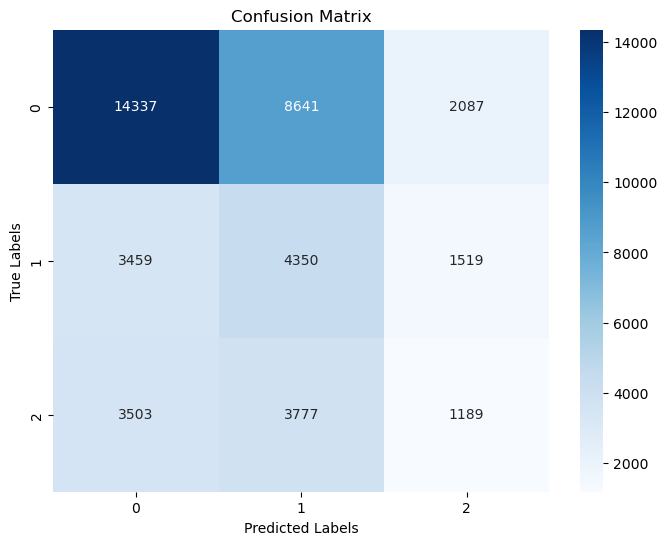

Classification Metrics:
Accuracy: 0.46
Precision: 0.39
Recall: 0.39
F1 Score: 0.38

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62     25065
           1       0.26      0.47      0.33      9328
           2       0.25      0.14      0.18      8469

    accuracy                           0.46     42862
   macro avg       0.39      0.39      0.38     42862
weighted avg       0.50      0.46      0.47     42862

{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2', 'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4', 'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6', 'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8', 'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10', 'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12', 'crypto_symbol_embedding_13', 'crypto_symb

In [82]:
# Just trying a different test train percentage, and also combinations of columns
results_arr_2 = []
input_columns = comb_1
for balancer in [1,1.5,2]: 
    try:
        print('preprocessing...')
        input_window = input_window #***
        output_window = output_window #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                    
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-12-01 00:00:00", valid_end_date="2024-03-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)
        
        # Apply rebalancing
        X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)

        print("affter balancing distribution:")
        print(X_train.shape)
        print('borrow_rate_Y_train:', np.bincount(borrow_rate_Y_train.flatten()))
        print('borrow_rate_Y_valid:',np.bincount(borrow_rate_Y_valid.flatten()))
        print('borrow_rate_Y_test:',np.bincount(borrow_rate_Y_test.flatten()))
        Y_test, y_pred = pre.train_v2(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True)
        
        accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = True)

        total_windows = Y_test.shape[0]
            
        new_row = {
            'columns': f'{input_columns}',
            'balancer': f'{balancer}',
            'total_windows':total_windows,
            'input_window':input_window,
            'output_window':output_window, 
            'outlier_threshold':outlier_threshold, 
            'accuracy':accuracy, 
            'precision':precision, 
            'recall':recall, 
            'f1':f1
        }
        results_arr_2.append(new_row)
        print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_2)

In [83]:
results.to_csv('data_balance_effect_v3.csv')
results

,columns,balancer,total_windows,input_window,output_window,outlier_threshold,accuracy,precision,recall,f1
0,"['lending_rate', 'borrowing_rate', 'utilizatio...",1,42862,48,48,remove,0.460058,0.401436,0.397972,0.379536
1,"['lending_rate', 'borrowing_rate', 'utilizatio...",1.5,42862,48,48,remove,0.471747,0.379395,0.376955,0.365336
2,"['lending_rate', 'borrowing_rate', 'utilizatio...",2,42862,48,48,remove,0.463721,0.393507,0.392908,0.377040


In [97]:
# lets check our feature importance
import ast
df_check = pd.read_csv('results_feature_importance_v3.csv')
df_check.sort_values('accuracy', inplace = True)
df_check.reset_index(inplace=True, drop=True)
for i in range(len(df_check)):
     print(round(df_check.loc[i,'f1'],2))
     x = ast.literal_eval(df_check.loc[i,'columns'])
     difference = np.setdiff1d(comb_1, x)
     print(difference)

# it seems like the embeddings and the time are having a bad effect because as we delete them the accuracy goes up
# it also seems like price, volume, yield and market cap are the most important

0.21
['attention' 'close' 'market_cap' 'returns' 'volume' 'yield']
0.27
[]
0.3
['market_cap' 'yield']
0.3
['lending_rate']
0.3
['borrowing_rate']
0.32
['borrowing_rate' 'lending_rate' 'utilization_rate']
0.31
['Day_Cosine' 'Day_Sine' 'DayofWeek_Cosine' 'DayofWeek_Sine' 'Hour_Cosine'
 'Hour_Sine' 'Month_Cosine' 'Month_Sine']
0.35
['crypto_symbol_embedding_1' 'crypto_symbol_embedding_10'
 'crypto_symbol_embedding_11' 'crypto_symbol_embedding_12'
 'crypto_symbol_embedding_13' 'crypto_symbol_embedding_14'
 'crypto_symbol_embedding_15' 'crypto_symbol_embedding_2'
 'crypto_symbol_embedding_3' 'crypto_symbol_embedding_4'
 'crypto_symbol_embedding_5' 'crypto_symbol_embedding_6'
 'crypto_symbol_embedding_7' 'crypto_symbol_embedding_8'
 'crypto_symbol_embedding_9']


In [99]:
# we will now try models where we delete each feature to see the effect, but we will not have embeddings and time in time dimensions in them
comb_9 = ['lending_rate', 'borrowing_rate', 'utilization_rate','close', 'volume', 'yield', 'market_cap', 'attention','returns'] 
comb_10 = ['borrowing_rate','close', 'volume', 'yield', 'market_cap', 'attention','returns']
comb_11 = ['close', 'volume', 'yield', 'market_cap', 'attention','returns']
comb_12 = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'volume', 'yield', 'market_cap', 'attention','returns']
comb_13 = ['lending_rate', 'borrowing_rate', 'utilization_rate','close', 'yield', 'market_cap', 'attention','returns']  
comb_14 = ['lending_rate', 'borrowing_rate', 'utilization_rate','close', 'volume', 'market_cap', 'attention','returns'] 
comb_15 = ['lending_rate', 'borrowing_rate', 'utilization_rate','close', 'volume', 'yield', 'attention','returns'] 
comb_16 = ['lending_rate', 'borrowing_rate', 'utilization_rate','close', 'volume', 'yield', 'market_cap','returns'] 
comb_17 = ['lending_rate', 'borrowing_rate', 'utilization_rate','close', 'volume', 'yield', 'market_cap', 'attention'] 
# if the results without the rates were etter you should also try rates without outliers

In [100]:
outlier_threshold = 'remove'
input_window = 48
output_window = 48
epoch_num = 40
bacth_size = 100
d1 = 0.1
d2 = 0.05
cell_size = 80
input_columns_list_2 = [comb_9, comb_10, comb_11, comb_12, comb_13, comb_14, comb_15, comb_16, comb_17]

preprocessing...
length of train, valid, test: 
(83634, 48, 9)
(42245, 48, 9)
(42862, 48, 9)
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 9)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28800     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 48, 80)            0         
                                                                 
 lstm_1 (LSTM)               (None, 40)                19360     
                                                                 
 batch_normalization_1

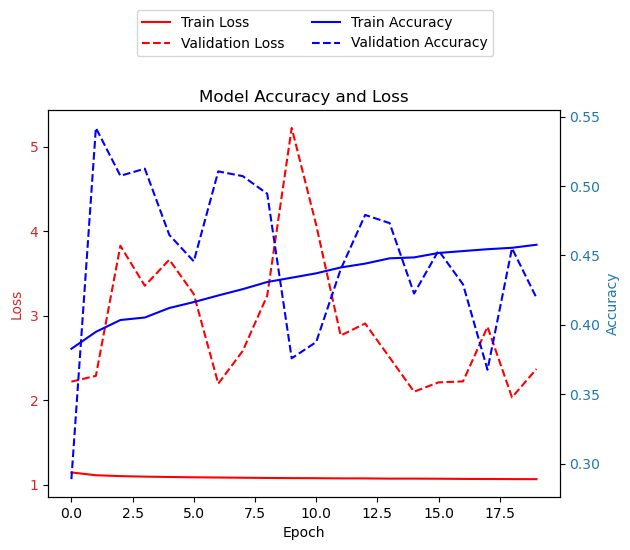

1340/1340 [==============================] - 12s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.29440996687042137, 'precision': 0.43878010443995613, 'recall': 0.3654053983118366, 'f1': 0.23477521771465035}
preprocessing...
length of train, valid, test: 
(83634, 48, 7)
(42245, 48, 7)
(42862, 48, 7)
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28160     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Nor

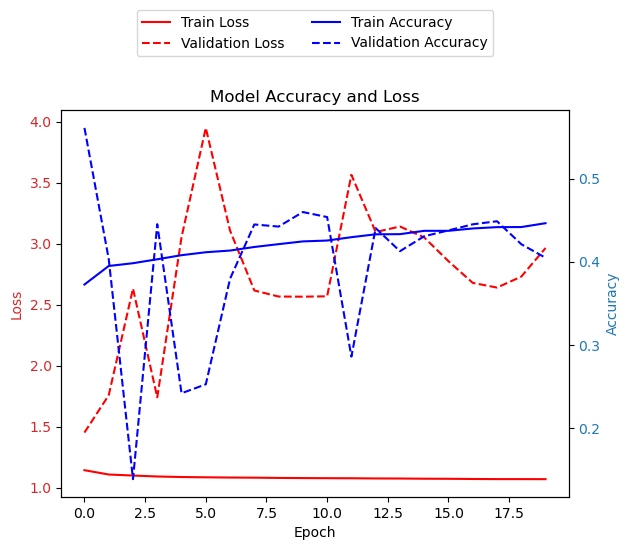

1340/1340 [==============================] - 11s 8ms/step
{'columns': "['borrowing_rate', 'close', 'volume', 'yield', 'market_cap', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.21149269749428398, 'precision': 0.35498781447068967, 'recall': 0.3412072712965419, 'f1': 0.12695556125446913}
preprocessing...
length of train, valid, test: 
(83634, 48, 6)
(42245, 48, 6)
(42862, 48, 6)
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            27840     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)                         

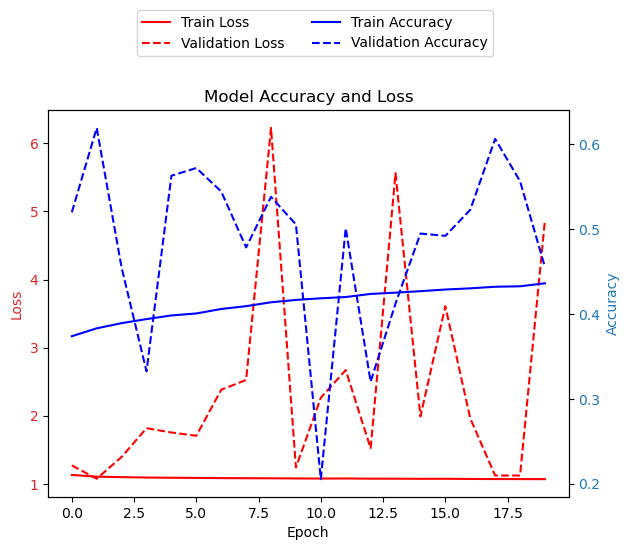

1340/1340 [==============================] - 13s 9ms/step
{'columns': "['close', 'volume', 'yield', 'market_cap', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.3785870934627409, 'precision': 0.3688931199846676, 'recall': 0.36629947645648847, 'f1': 0.34490414129321606}
preprocessing...
length of train, valid, test: 
(83634, 48, 8)
(42245, 48, 8)
(42862, 48, 8)
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28480     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)                                            

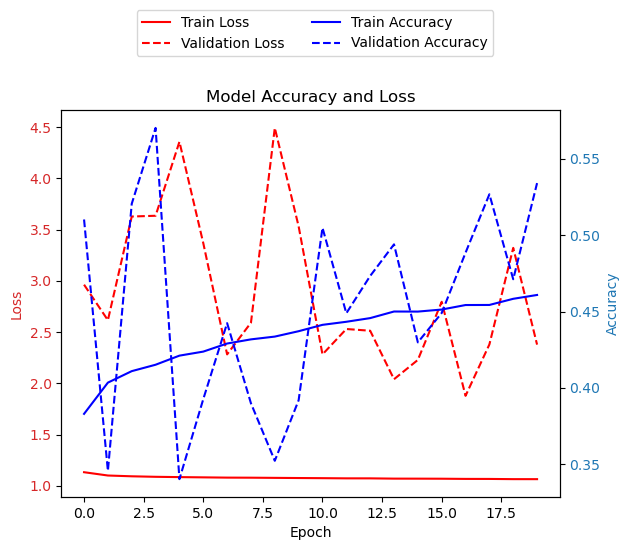

1340/1340 [==============================] - 13s 9ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'volume', 'yield', 'market_cap', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.4845317530679856, 'precision': 0.4330160514927793, 'recall': 0.36111097127312336, 'f1': 0.3274228127008743}
preprocessing...
length of train, valid, test: 
(83634, 48, 8)
(42245, 48, 8)
(42862, 48, 8)
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28480     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)

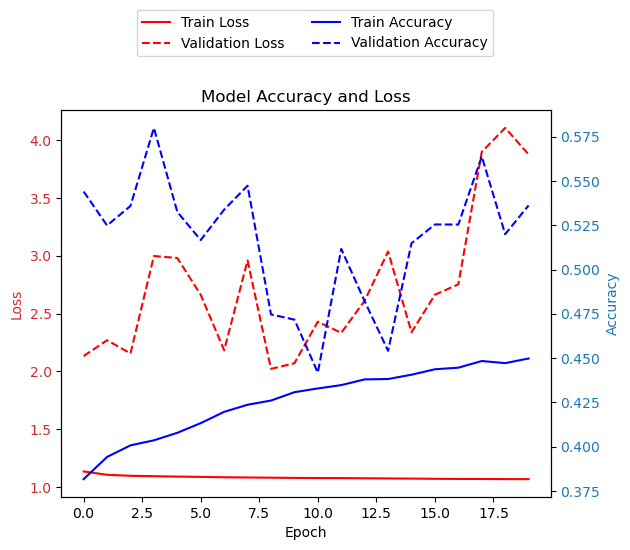

1340/1340 [==============================] - 12s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'yield', 'market_cap', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.4423265363258831, 'precision': 0.37911503376183897, 'recall': 0.3513201629176717, 'f1': 0.31336689317597527}
preprocessing...
length of train, valid, test: 
(83634, 48, 8)
(42245, 48, 8)
(42862, 48, 8)
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28480     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)

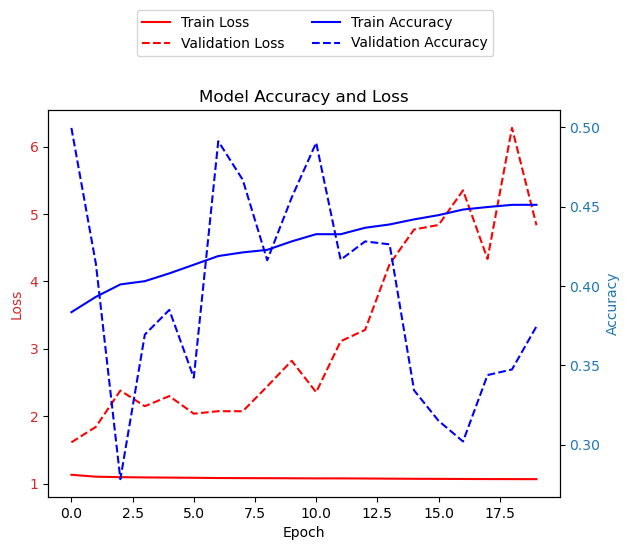

1340/1340 [==============================] - 12s 9ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'market_cap', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.3027390229107368, 'precision': 0.5191137219407845, 'recall': 0.38638398902385546, 'f1': 0.2571640958495798}
preprocessing...
length of train, valid, test: 
(83634, 48, 8)
(42245, 48, 8)
(42862, 48, 8)
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28480     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)

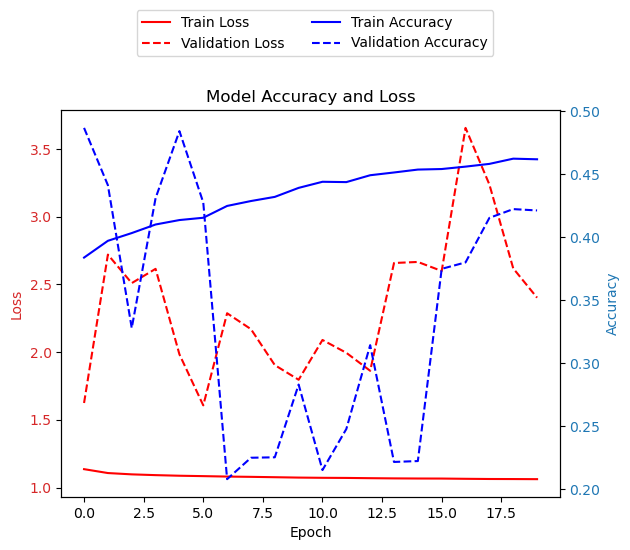

1340/1340 [==============================] - 12s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.3968083617190052, 'precision': 0.5193814235132411, 'recall': 0.3510304421633587, 'f1': 0.28657242128617527}
preprocessing...
length of train, valid, test: 
(83634, 48, 8)
(42245, 48, 8)
(42862, 48, 8)
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28480     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)     

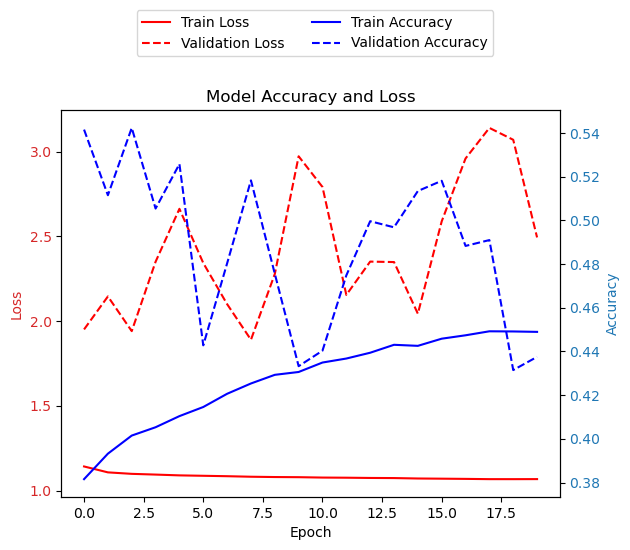

1340/1340 [==============================] - 14s 10ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.3646353413279828, 'precision': 0.4087009565287418, 'recall': 0.40003268027015576, 'f1': 0.3543244813917317}
preprocessing...
length of train, valid, test: 
(83634, 48, 8)
(42245, 48, 8)
(42862, 48, 8)
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28480     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)   

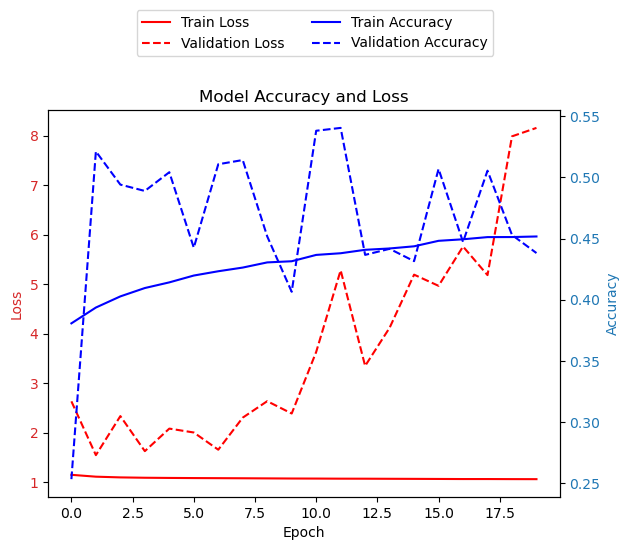

1340/1340 [==============================] - 12s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'close', 'volume', 'yield', 'market_cap', 'attention']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.31645746815360926, 'precision': 0.29331273996623436, 'recall': 0.3502725715124382, 'f1': 0.23864292940383133}


In [ ]:
# Just trying a different test train percentage, and also combinations of columns
results_arr_5 = []
for input_columns in input_columns_list_2: 
    try:
        print('preprocessing...')
        input_window = input_window #***
        output_window = output_window #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-09-01 00:00:00", valid_end_date="2024-03-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)

        print('Training...')
        Y_test, y_pred = pre.train_v2(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True)
        
        accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

        total_windows = Y_test.shape[0]
            
        new_row = {
            'columns': f'{input_columns}',
            'total_windows':total_windows,
            'input_window':input_window,
            'output_window':output_window, 
            'outlier_threshold':outlier_threshold, 
            'accuracy':accuracy, 
            'precision':precision, 
            'recall':recall, 
            'f1':f1
        }
        results_arr_5.append(new_row)
        print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_5)

In [102]:
results.to_csv('feature_importance_v6.csv')
results

,columns,total_windows,input_window,output_window,outlier_threshold,accuracy,precision,recall,f1
0,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.294410,0.438780,0.365405,0.234775
1,"['borrowing_rate', 'close', 'volume', 'yield',...",42862,48,48,remove,0.211493,0.354988,0.341207,0.126956
2,"['close', 'volume', 'yield', 'market_cap', 'at...",42862,48,48,remove,0.378587,0.368893,0.366299,0.344904
3,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.484532,0.433016,0.361111,0.327423
4,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.442327,0.379115,0.351320,0.313367
5,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.302739,0.519114,0.386384,0.257164
6,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.396808,0.519381,0.351030,0.286572
7,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.364635,0.408701,0.400033,0.354324
8,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.316457,0.293313,0.350273,0.238643


In [ ]:
# checking the feature importance results based on f1 score
import ast
results_1 = pd.read_csv('results_feature_importance_v3.csv')
results_2 = pd.read_csv('feature_importance_v6.csv')
df_check = pd.concat([results_1, results_2],axis = 0)
df_check.sort_values('accuracy', inplace = True, ascending=False)
df_check.reset_index(inplace=True, drop=True)
for i in range(len(df_check)):
     print('accuracy',round(df_check.loc[i,'accuracy'],2))
     print('f1 score',round(df_check.loc[i,'f1'],2))
     x = ast.literal_eval(df_check.loc[i,'columns'])
     difference = np.setdiff1d(comb_1, x)
     print(difference)

# seems like volume and close are playig a negative role

accuracy 0.48
f1 score 0.33
['Day_Cosine' 'Day_Sine' 'DayofWeek_Cosine' 'DayofWeek_Sine' 'Hour_Cosine'
 'Hour_Sine' 'Month_Cosine' 'Month_Sine' 'close'
 'crypto_symbol_embedding_1' 'crypto_symbol_embedding_10'
 'crypto_symbol_embedding_11' 'crypto_symbol_embedding_12'
 'crypto_symbol_embedding_13' 'crypto_symbol_embedding_14'
 'crypto_symbol_embedding_15' 'crypto_symbol_embedding_2'
 'crypto_symbol_embedding_3' 'crypto_symbol_embedding_4'
 'crypto_symbol_embedding_5' 'crypto_symbol_embedding_6'
 'crypto_symbol_embedding_7' 'crypto_symbol_embedding_8'
 'crypto_symbol_embedding_9']
accuracy 0.44
f1 score 0.31
['Day_Cosine' 'Day_Sine' 'DayofWeek_Cosine' 'DayofWeek_Sine' 'Hour_Cosine'
 'Hour_Sine' 'Month_Cosine' 'Month_Sine' 'crypto_symbol_embedding_1'
 'crypto_symbol_embedding_10' 'crypto_symbol_embedding_11'
 'crypto_symbol_embedding_12' 'crypto_symbol_embedding_13'
 'crypto_symbol_embedding_14' 'crypto_symbol_embedding_15'
 'crypto_symbol_embedding_2' 'crypto_symbol_embedding_3'
 'crypt

preprocessing...
length of train, valid, test: 
(83634, 48, 7)
(42245, 48, 7)
(42862, 48, 7)
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 7)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28160     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 48, 80)            0         
                                                                 
 lstm_1 (LSTM)               (None, 40)                19360     
                                                                 
 batch_normalization_1

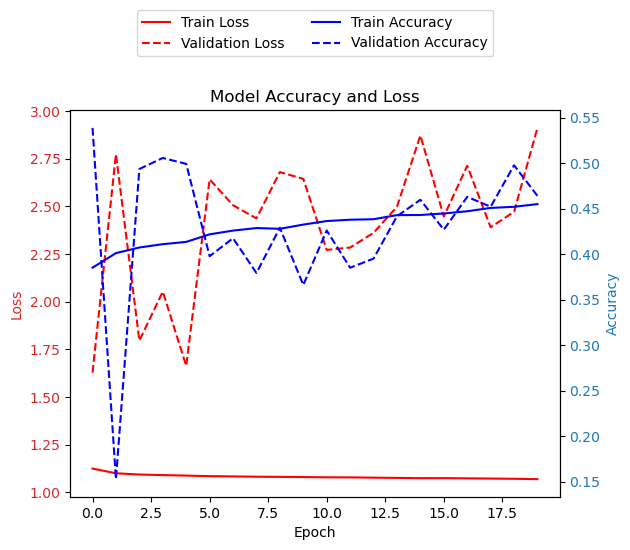

1340/1340 [==============================] - 17s 12ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns']", 'total_windows': 42862, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.3293593392748822, 'precision': 0.2569794079279078, 'recall': 0.33716931090747476, 'f1': 0.24483544598348414}


In [107]:
# testing without volume and close
results_arr_5 = []
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns'] 
input_columns_list_3 = [input_columns]
for input_columns in input_columns_list_3: 
    try:
        print('preprocessing...')
        input_window = input_window #***
        output_window = output_window #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-09-01 00:00:00", valid_end_date="2024-03-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)

        print('Training...')
        Y_test, y_pred = pre.train_v2(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True)
        
        accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

        total_windows = Y_test.shape[0]
            
        new_row = {
            'columns': f'{input_columns}',
            'total_windows':total_windows,
            'input_window':input_window,
            'output_window':output_window, 
            'outlier_threshold':outlier_threshold, 
            'accuracy':accuracy, 
            'precision':precision, 
            'recall':recall, 
            'f1':f1
        }
        results_arr_5.append(new_row)
        print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_5)

In [108]:
results.to_csv('feature_importance_v7.csv')
results

,columns,total_windows,input_window,output_window,outlier_threshold,accuracy,precision,recall,f1
0,"['lending_rate', 'borrowing_rate', 'utilizatio...",42862,48,48,remove,0.329359,0.256979,0.337169,0.244835


In [109]:
# lets check our feature importance for the third time
import ast
results_1 = pd.read_csv('results_feature_importance_v3.csv')
results_2 = pd.read_csv('feature_importance_v6.csv')
results_3 = pd.read_csv('feature_importance_v7.csv')
df_check = pd.concat([results_1, results_2, results_3],axis = 0)
df_check.sort_values('accuracy', inplace = True, ascending=False)
df_check.reset_index(inplace=True, drop=True)
for i in range(len(df_check)):
     print('accuracy',round(df_check.loc[i,'accuracy'],2))
     print('f1 score',round(df_check.loc[i,'f1'],2))
     x = ast.literal_eval(df_check.loc[i,'columns'])
     difference = np.setdiff1d(comb_1, x)
     print(difference)

accuracy 0.48
f1 score 0.33
['Day_Cosine' 'Day_Sine' 'DayofWeek_Cosine' 'DayofWeek_Sine' 'Hour_Cosine'
 'Hour_Sine' 'Month_Cosine' 'Month_Sine' 'close'
 'crypto_symbol_embedding_1' 'crypto_symbol_embedding_10'
 'crypto_symbol_embedding_11' 'crypto_symbol_embedding_12'
 'crypto_symbol_embedding_13' 'crypto_symbol_embedding_14'
 'crypto_symbol_embedding_15' 'crypto_symbol_embedding_2'
 'crypto_symbol_embedding_3' 'crypto_symbol_embedding_4'
 'crypto_symbol_embedding_5' 'crypto_symbol_embedding_6'
 'crypto_symbol_embedding_7' 'crypto_symbol_embedding_8'
 'crypto_symbol_embedding_9']
accuracy 0.44
f1 score 0.31
['Day_Cosine' 'Day_Sine' 'DayofWeek_Cosine' 'DayofWeek_Sine' 'Hour_Cosine'
 'Hour_Sine' 'Month_Cosine' 'Month_Sine' 'crypto_symbol_embedding_1'
 'crypto_symbol_embedding_10' 'crypto_symbol_embedding_11'
 'crypto_symbol_embedding_12' 'crypto_symbol_embedding_13'
 'crypto_symbol_embedding_14' 'crypto_symbol_embedding_15'
 'crypto_symbol_embedding_2' 'crypto_symbol_embedding_3'
 'crypt

### This combination gave the best result:
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns', 'volume'] 

### performing grid search on windows again

In [112]:
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns', 'volume'] 
input_output_combination = [
     {'input':8, 'output':8},
     {'input':24, 'output':8},
     {'input':24, 'output':24},
     {'input':48, 'output':8},
     {'input':48, 'output':24},
     {'input':48, 'output':48},
     {'input':96, 'output':8},
     {'input':96, 'output':24},
     {'input':96, 'output':48},
     {'input':96, 'output':96},
     {'input':192, 'output':8},
     {'input':192, 'output':24},
     {'input':192, 'output':48},
     {'input':192, 'output':96},
     {'input':192, 'output':192},
]
balancer = 2
outlier_threshold = 'remove'
epoch_num = 50
bacth_size = 100

preprocessing...
length of train, valid, test: 
(193014, 8, 8)
(57441, 8, 8)
(70988, 8, 8)
affter balancing distribution:
(193014, 8, 8)
borrow_rate_Y_train: [86837 50573 55604]
borrow_rate_Y_valid: [47327  7877  2237]
borrow_rate_Y_test: [62289  4379  4320]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8)]            0         
                                                                 
 lstm (LSTM)                 (None, 8, 80)             28480     
                                                                 
 batch_normalization (Batch  (None, 8, 80)             320       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 8, 80)             0         
                                                      

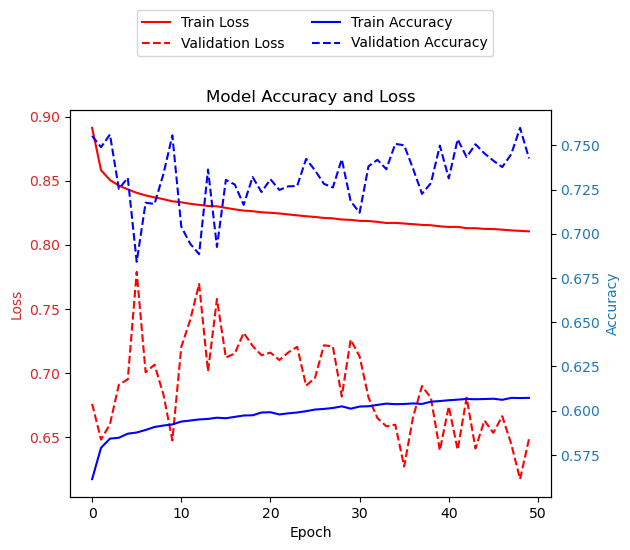

2219/2219 [==============================] - 6s 2ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 70988, 'input_window': 8, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.781005240322308, 'precision': 0.356198940584392, 'recall': 0.35785746870366375, 'f1': 0.35690398682146474}
preprocessing...
length of train, valid, test: 
(148736, 24, 8)
(53198, 24, 8)
(67707, 24, 8)
affter balancing distribution:
(148736, 24, 8)
borrow_rate_Y_train: [73259 36826 38651]
borrow_rate_Y_valid: [44648  6954  1596]
borrow_rate_Y_test: [59688  4098  3921]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 24, 80

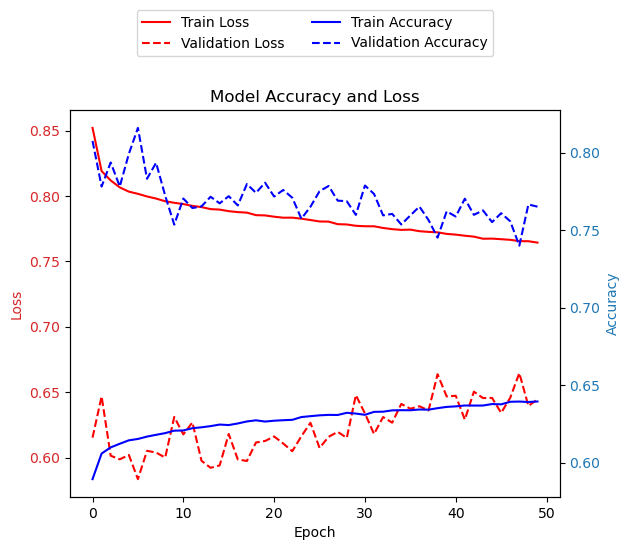

2116/2116 [==============================] - 11s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 67707, 'input_window': 24, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.7277238690238823, 'precision': 0.35145841318538734, 'recall': 0.3608899035861992, 'f1': 0.350062592001073}
preprocessing...
length of train, valid, test: 
(118686, 24, 8)
(49656, 24, 8)
(64646, 24, 8)
affter balancing distribution:
(118686, 24, 8)
borrow_rate_Y_train: [38679 41198 38809]
borrow_rate_Y_valid: [33861 12711  3084]
borrow_rate_Y_test: [46496  9331  8819]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 24, 

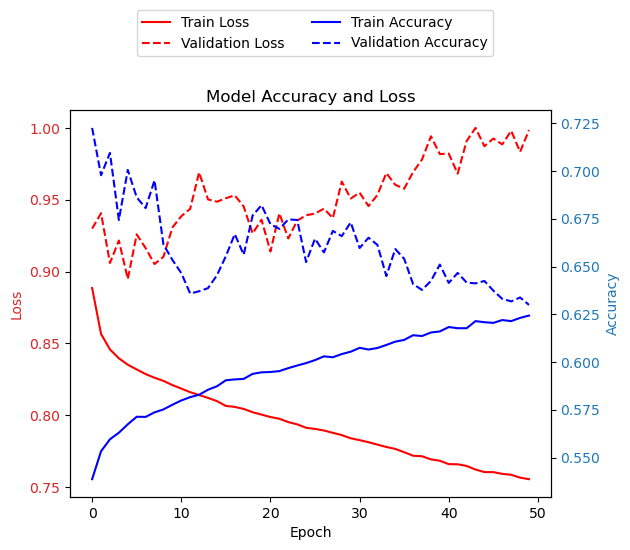

2021/2021 [==============================] - 11s 5ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 64646, 'input_window': 24, 'output_window': 24, 'outlier_threshold': 'remove', 'accuracy': 0.3635955820932463, 'precision': 0.36066522654648064, 'recall': 0.35689301226397235, 'f1': 0.3028867992902031}
preprocessing...
length of train, valid, test: 
(107249, 48, 8)
(48058, 48, 8)
(63198, 48, 8)
affter balancing distribution:
(96794, 48, 8)
borrow_rate_Y_train: [48228 24452 24114]
borrow_rate_Y_valid: [41030  5759  1269]
borrow_rate_Y_test: [56085  3642  3471]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48

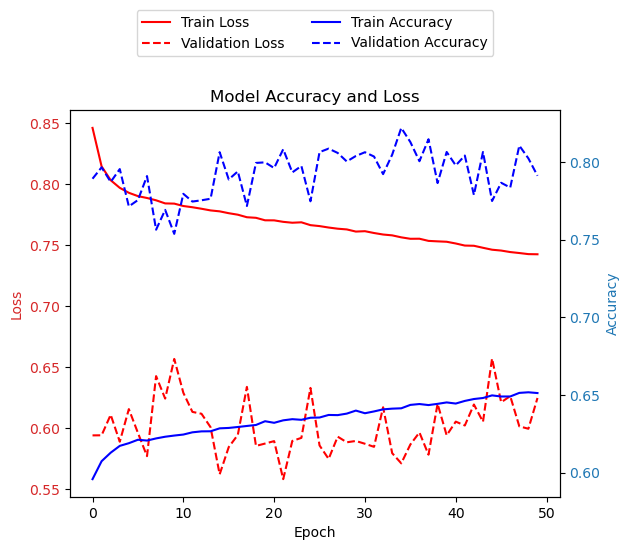

1975/1975 [==============================] - 18s 9ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 63198, 'input_window': 48, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.7644703946327416, 'precision': 0.3493818280805204, 'recall': 0.36294469241455896, 'f1': 0.3461639131696416}
preprocessing...
length of train, valid, test: 
(89308, 48, 8)
(45129, 48, 8)
(60466, 48, 8)
affter balancing distribution:
(89308, 48, 8)
borrow_rate_Y_train: [33581 29546 26181]
borrow_rate_Y_valid: [31417 11154  2558]
borrow_rate_Y_test: [44196  8400  7870]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 8

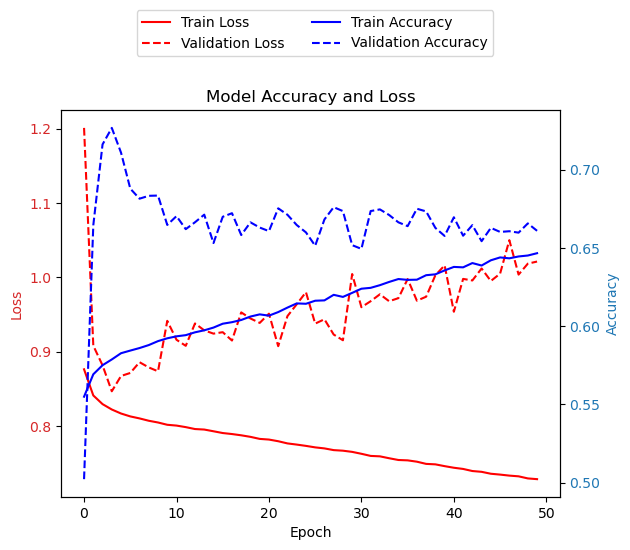

1890/1890 [==============================] - 17s 9ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 60466, 'input_window': 48, 'output_window': 24, 'outlier_threshold': 'remove', 'accuracy': 0.5294214930704859, 'precision': 0.34591954148070553, 'recall': 0.34512082807004424, 'f1': 0.3415599912122716}
preprocessing...
length of train, valid, test: 
(70549, 48, 8)
(41323, 48, 8)
(56869, 48, 8)
affter balancing distribution:
(70549, 48, 8)
borrow_rate_Y_train: [20945 27433 22171]
borrow_rate_Y_valid: [23487 14377  3459]
borrow_rate_Y_test: [32957 12219 11693]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48,

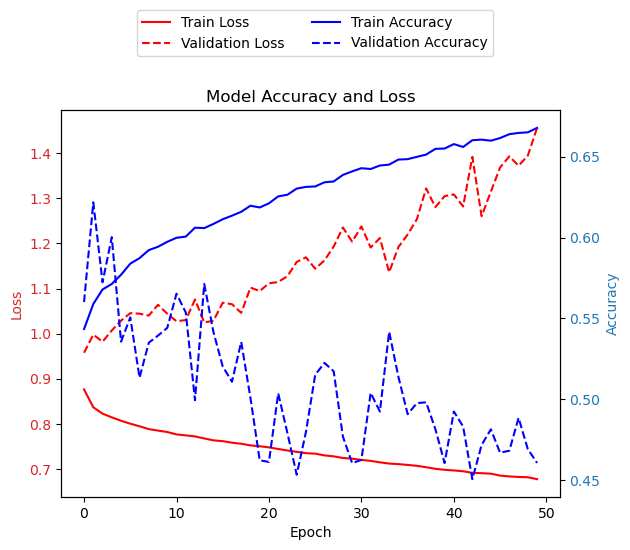

1778/1778 [==============================] - 16s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.420141025866465, 'precision': 0.353036817048908, 'recall': 0.3511179515420444, 'f1': 0.348688550091973}
preprocessing...
length of train, valid, test: 
(65814, 96, 8)
(40212, 96, 8)
(55755, 96, 8)
affter balancing distribution:
(48155, 96, 8)
borrow_rate_Y_train: [23540 12845 11770]
borrow_rate_Y_valid: [35082  4278   852]
borrow_rate_Y_test: [49910  2985  2860]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 96, 80) 

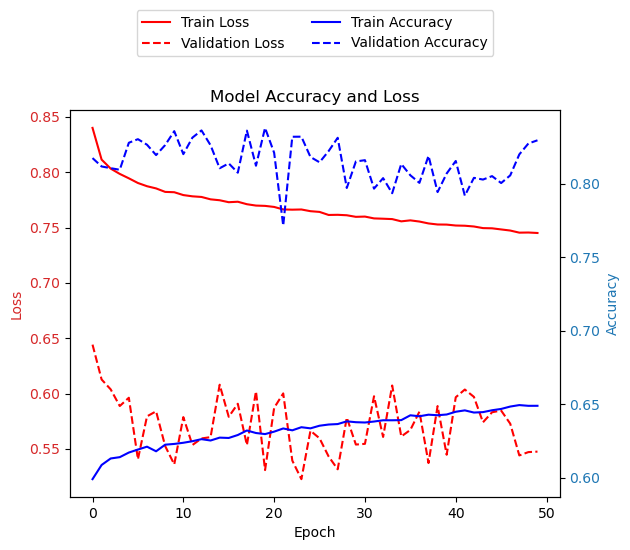

1743/1743 [==============================] - 29s 16ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.8293426598511344, 'precision': 0.3753058978993147, 'recall': 0.3753057682945551, 'f1': 0.37074776650907654}
preprocessing...
length of train, valid, test: 
(57657, 96, 8)
(38125, 96, 8)
(53630, 96, 8)
affter balancing distribution:
(57657, 96, 8)
borrow_rate_Y_train: [26285 17496 13876]
borrow_rate_Y_valid: [27675  8655  1795]
borrow_rate_Y_test: [40019  6955  6656]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 96, 

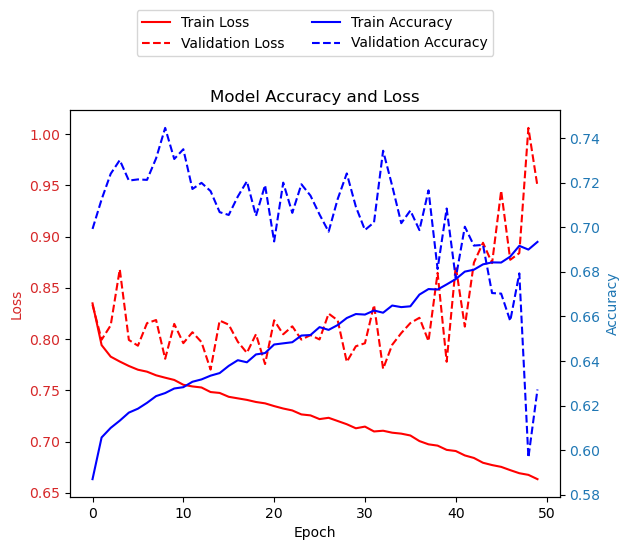

1676/1676 [==============================] - 28s 16ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 53630, 'input_window': 96, 'output_window': 24, 'outlier_threshold': 'remove', 'accuracy': 0.6313257505127727, 'precision': 0.3614410538376575, 'recall': 0.35739404000092007, 'f1': 0.35649731674325813}
preprocessing...
length of train, valid, test: 
(48456, 96, 8)
(35304, 96, 8)
(50719, 96, 8)
affter balancing distribution:
(48456, 96, 8)
borrow_rate_Y_train: [17602 18139 12715]
borrow_rate_Y_valid: [21200 11656  2448]
borrow_rate_Y_test: [30291 10275 10153]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 96

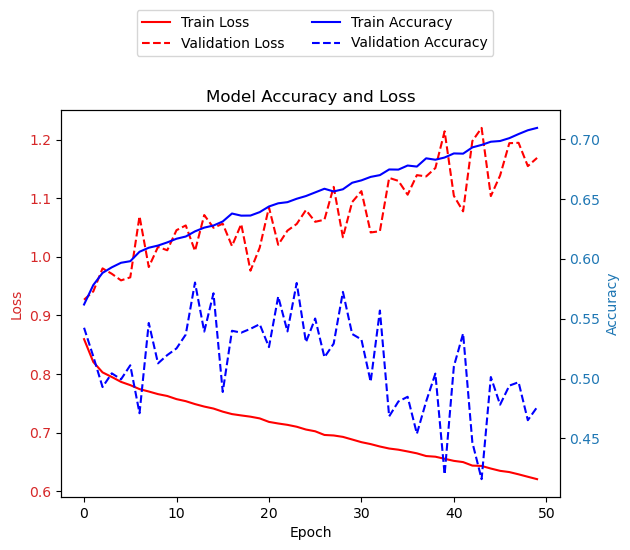

1585/1585 [==============================] - 27s 16ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 50719, 'input_window': 96, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.5069697746406672, 'precision': 0.35381413125186306, 'recall': 0.35084972482151744, 'f1': 0.3396285558930047}
preprocessing...
length of train, valid, test: 
(36628, 96, 8)
(30623, 96, 8)
(45558, 96, 8)
affter balancing distribution:
(36628, 96, 8)
borrow_rate_Y_train: [10416 17019  9193]
borrow_rate_Y_valid: [13354 14716  2553]
borrow_rate_Y_test: [18608 13365 13585]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 96

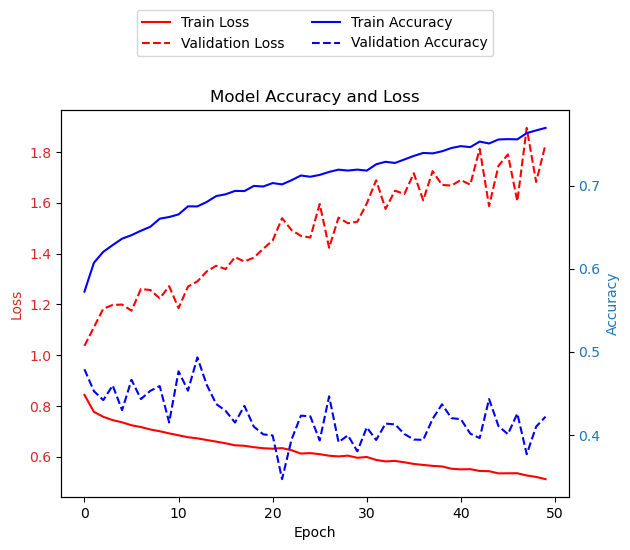

1424/1424 [==============================] - 24s 16ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 45558, 'input_window': 96, 'output_window': 96, 'outlier_threshold': 'remove', 'accuracy': 0.4095877782167786, 'precision': 0.4030256161262616, 'recall': 0.4014296181934784, 'f1': 0.397371698860616}
preprocessing...
length of train, valid, test: 
(35242, 192, 8)
(29932, 192, 8)
(44775, 192, 8)
affter balancing distribution:
(17824, 192, 8)
borrow_rate_Y_train: [8310 5359 4155]
borrow_rate_Y_valid: [26746  2665   521]
borrow_rate_Y_test: [40610  2038  2127]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 8)]          0         
                                                                 
 lstm (LSTM)                 (None, 192,

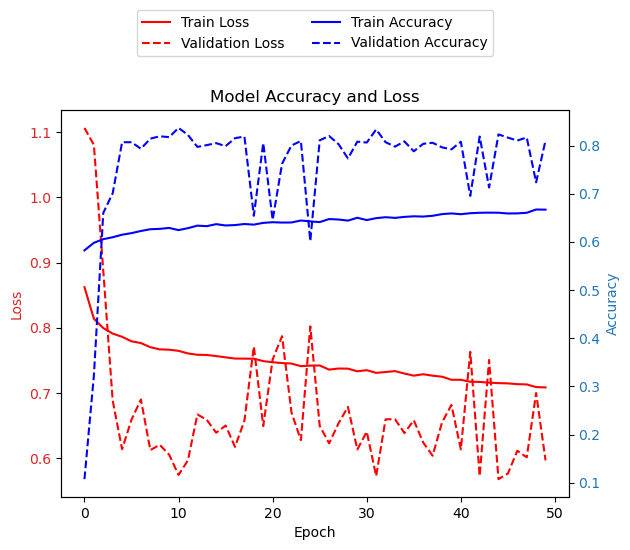

1400/1400 [==============================] - 45s 32ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 44775, 'input_window': 192, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.7713009491903964, 'precision': 0.3549894895944683, 'recall': 0.3511791663889703, 'f1': 0.3286445212108017}
preprocessing...
length of train, valid, test: 
(32699, 192, 8)
(28591, 192, 8)
(43261, 192, 8)
affter balancing distribution:
(24687, 192, 8)
borrow_rate_Y_train: [10794  8496  5397]
borrow_rate_Y_valid: [21722  5776  1093]
borrow_rate_Y_test: [33295  4935  5031]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 8)]          0         
                                                                 
 lstm (LSTM)                 (None, 

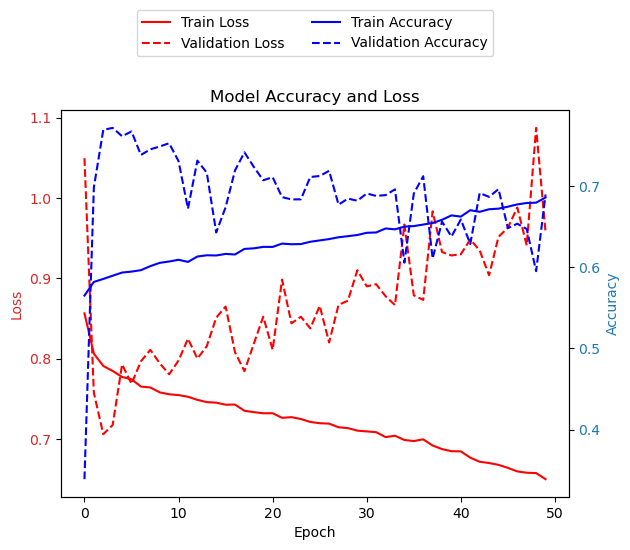

1352/1352 [==============================] - 44s 32ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 43261, 'input_window': 192, 'output_window': 24, 'outlier_threshold': 'remove', 'accuracy': 0.6782552414414831, 'precision': 0.3579308566589518, 'recall': 0.3756876174611296, 'f1': 0.36065520180189714}
preprocessing...
length of train, valid, test: 
(29383, 192, 8)
(26781, 192, 8)
(41126, 192, 8)
affter balancing distribution:
(26704, 192, 8)
borrow_rate_Y_train: [11088 10072  5544]
borrow_rate_Y_valid: [16756  8592  1433]
borrow_rate_Y_test: [25646  7590  7890]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 8)]          0         
                                                                 
 lstm (LSTM)                 (None

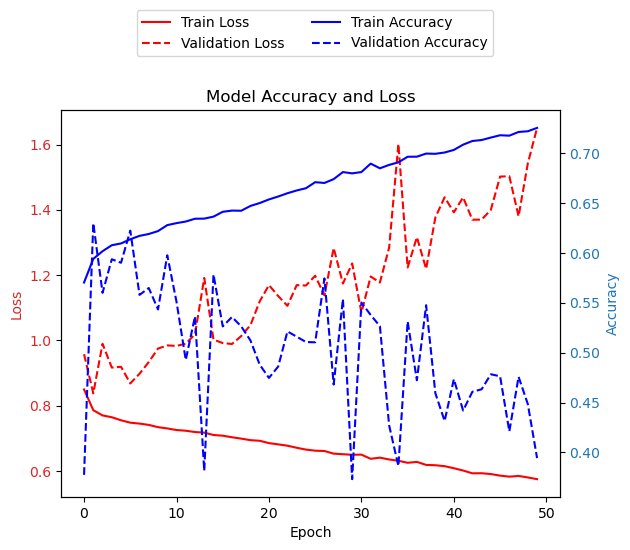

1286/1286 [==============================] - 41s 32ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 41126, 'input_window': 192, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.5154889850702719, 'precision': 0.3584315442361408, 'recall': 0.3633391991779311, 'f1': 0.35036098028966495}
preprocessing...
length of train, valid, test: 
(24469, 192, 8)
(23695, 192, 8)
(37239, 192, 8)
affter balancing distribution:
(23111, 192, 8)
borrow_rate_Y_train: [8828 9522 4761]
borrow_rate_Y_valid: [10765 11539  1391]
borrow_rate_Y_test: [16051 10115 11073]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 8)]          0         
                                                                 
 lstm (LSTM)                 (None, 1

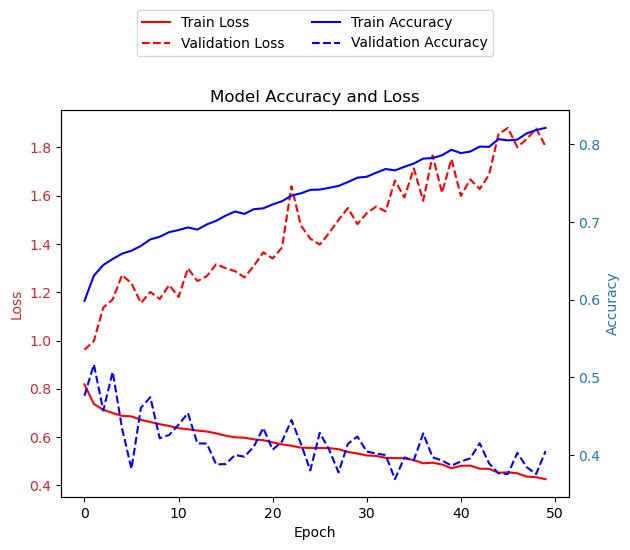

1164/1164 [==============================] - 41s 35ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 37239, 'input_window': 192, 'output_window': 96, 'outlier_threshold': 'remove', 'accuracy': 0.4047369693063724, 'precision': 0.38684479468315797, 'recall': 0.3853853348284198, 'f1': 0.3844344498435223}
preprocessing...
length of train, valid, test: 
(17566, 192, 8)
(18881, 192, 8)
(30596, 192, 8)
affter balancing distribution:
(14111, 192, 8)
borrow_rate_Y_train: [4490 6414 3207]
borrow_rate_Y_valid: [ 5342 12454  1085]
borrow_rate_Y_test: [ 7597 10574 12425]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 8)]          0         
                                                                 
 lstm (LSTM)                 (None, 1

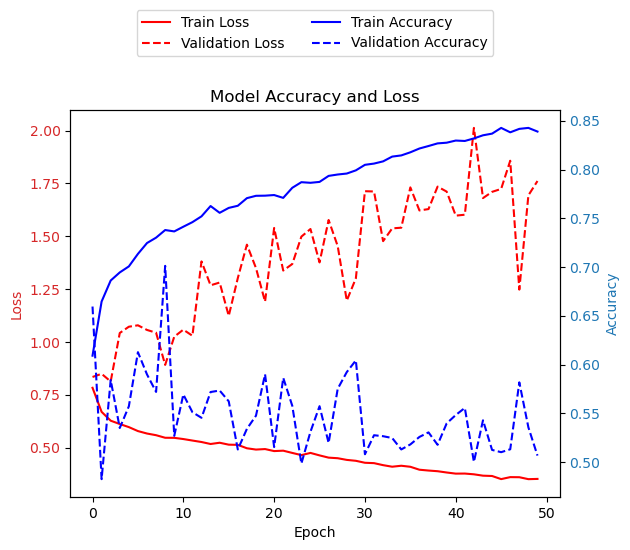

957/957 [==============================] - 35s 35ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 30596, 'input_window': 192, 'output_window': 192, 'outlier_threshold': 'remove', 'accuracy': 0.39126029546345925, 'precision': 0.38954505509070364, 'recall': 0.4065794777503487, 'f1': 0.3914881905304434}


In [113]:
# testing without volume and close
results_arr_6 = []
for comb in input_output_combination: 
    try:
        print('preprocessing...')
        input_window = comb['input'] #***
        output_window = comb['output'] #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)

        # Apply rebalancing
        X_train, borrow_rate_Y_train = pre.rebalance_classes_general(X_train, borrow_rate_Y_train, balance_ratio=balancer)

        print("affter balancing distribution:")
        print(X_train.shape)
        print('borrow_rate_Y_train:', np.bincount(borrow_rate_Y_train.flatten()))
        print('borrow_rate_Y_valid:',np.bincount(borrow_rate_Y_valid.flatten()))
        print('borrow_rate_Y_test:',np.bincount(borrow_rate_Y_test.flatten()))

        print('Training...')
        Y_test, y_pred = pre.train_v2(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, batch_size=bacth_size)
        
        accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

        total_windows = Y_test.shape[0]
            
        new_row = {
            'columns': f'{input_columns}',
            'total_test_windows':total_windows,
            'input_window':input_window,
            'output_window':output_window, 
            'outlier_threshold':outlier_threshold, 
            'accuracy':accuracy, 
            'precision':precision, 
            'recall':recall, 
            'f1':f1
        }
        results_arr_6.append(new_row)
        print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_6)

In [115]:
results.to_csv('window_check_v2.csv')
results

,columns,total_test_windows,input_window,output_window,outlier_threshold,accuracy,precision,recall,f1
0,"['lending_rate', 'borrowing_rate', 'utilizatio...",70988,8,8,remove,0.781005,0.356199,0.357857,0.356904
1,"['lending_rate', 'borrowing_rate', 'utilizatio...",67707,24,8,remove,0.727724,0.351458,0.360890,0.350063
2,"['lending_rate', 'borrowing_rate', 'utilizatio...",64646,24,24,remove,0.363596,0.360665,0.356893,0.302887
3,"['lending_rate', 'borrowing_rate', 'utilizatio...",63198,48,8,remove,0.764470,0.349382,0.362945,0.346164
4,"['lending_rate', 'borrowing_rate', 'utilizatio...",60466,48,24,remove,0.529421,0.345920,0.345121,0.341560
5,"['lending_rate', 'borrowing_rate', 'utilizatio...",56869,48,48,remove,0.420141,0.353037,0.351118,0.348689
6,"['lending_rate', 'borrowing_rate', 'utilizatio...",55755,96,8,remove,0.829343,0.375306,0.375306,0.370748
7,"['lending_rate', 'borrowing_rate', 'utilizatio...",53630,96,24,remove,0.631326,0.361441,0.357394,0.356497
8,"['lending_rate', 'borrowing_rate', 'utilizatio...",50719,96,48,remove,0.506970,0.353814,0.350850,0.339629
9,"['lending_rate', 'borrowing_rate', 'utilizatio...",45558,96,96,remove,0.409588,0.403026,0.401430,0.397372


### Trying weighted Loss functions
- We can see that 96 inputs and 8 outputs give us a good accuracy with 37% macro F1-score, therefore we will try to make this f1 score better.
- Also, we will Try weighting the classes on 48 input and 48 output as it results are a bit more logical.

In [15]:
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention','returns', 'volume'] 
input_output_combination = [
     {'input':48, 'output':48},
     {'input':96, 'output':8}
]
outlier_threshold = 'remove'
epoch_num = 50
bacth_size = 100

preprocessing...
length of train, valid, test: 
(70549, 48, 8)
(41323, 48, 8)
(56869, 48, 8)
distributions:
borrow_rate_Y_train: [20945 27433 22171]
borrow_rate_Y_valid: [23487 14377  3459]
borrow_rate_Y_test: [32957 12219 11693]
Training...
Class weights: {0: 3.3682979231320123, 1: 2.5716837385630447, 2: 3.1820396012809526}
Type of class_weights: <class 'dict'>



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28480     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)                                                  
                                                                 
 dropout (Dropout)     

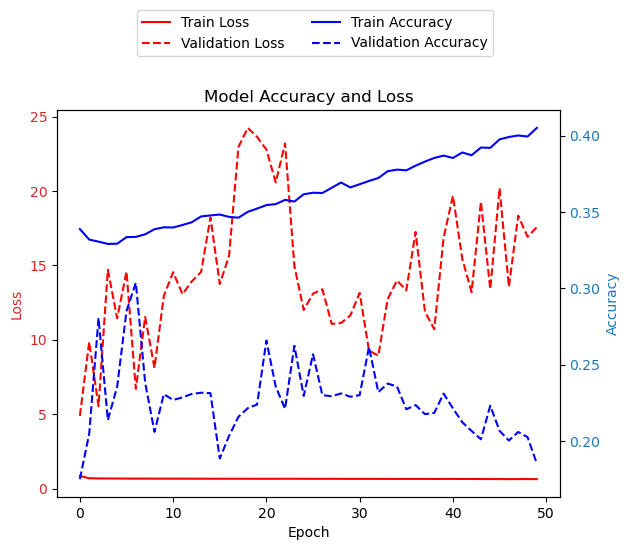

1778/1778 [==============================] - 14s 7ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'class_weights': '{0: 3.3682979231320123, 1: 2.5716837385630447, 2: 3.1820396012809526}', 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.2643443703951186, 'precision': 0.36403083246719753, 'recall': 0.3504747573975826, 'f1': 0.2551250371802454}
Class weights: {0: 6.0, 1: 1.0, 2: 1.0}
Type of class_weights: <class 'dict'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28480     
                                                                 
 batch_normal

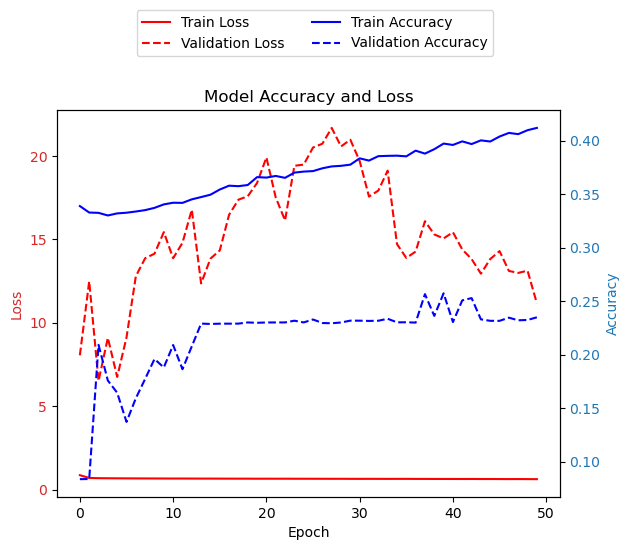

1778/1778 [==============================] - 14s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'class_weights': '{0: 6.0, 1: 1.0, 2: 1.0}', 'total_test_windows': 56869, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 'remove', 'accuracy': 0.22683711688266014, 'precision': 0.3084616705992812, 'recall': 0.35537453385108475, 'f1': 0.21621863604159816}
preprocessing...
length of train, valid, test: 
(65814, 96, 8)
(40212, 96, 8)
(55755, 96, 8)
distributions:
borrow_rate_Y_train: [41199 12845 11770]
borrow_rate_Y_valid: [35082  4278   852]
borrow_rate_Y_test: [49910  2985  2860]
Training...
Class weights: {0: 1.5974659579115997, 1: 5.123705722070845, 2: 5.5916737468139335}
Type of class_weights: <class 'dict'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(Non

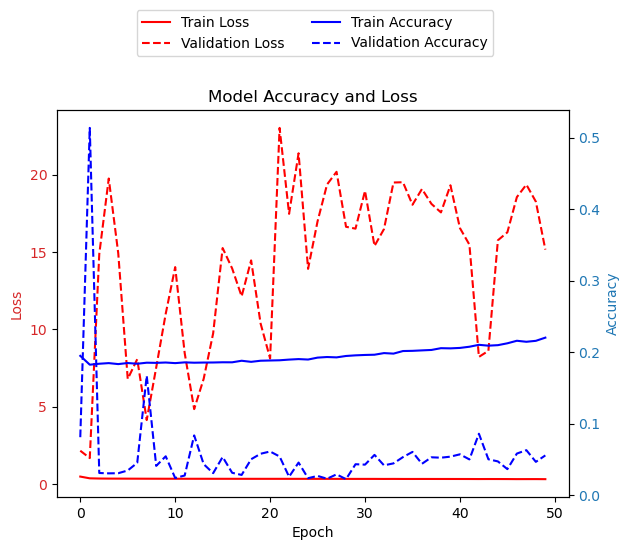

1743/1743 [==============================] - 25s 14ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'class_weights': '{0: 1.5974659579115997, 1: 5.123705722070845, 2: 5.5916737468139335}', 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.050112097569724685, 'precision': 0.03170311944017792, 'recall': 0.3232983097304705, 'f1': 0.055201987424652876}
Class weights: {0: 6.0, 1: 1.0, 2: 1.0}
Type of class_weights: <class 'dict'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 96, 80)            28480     
                                                                 
 batch_nor

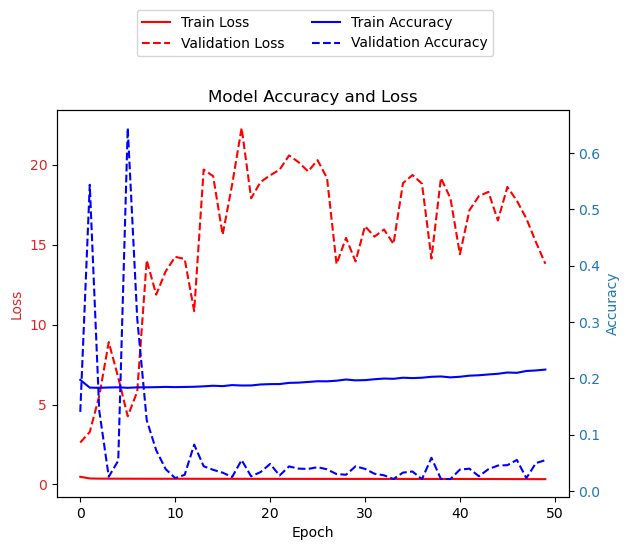

1743/1743 [==============================] - 25s 14ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'class_weights': '{0: 6.0, 1: 1.0, 2: 1.0}', 'total_test_windows': 55755, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 'remove', 'accuracy': 0.04824679400950587, 'precision': 0.034277587304652475, 'recall': 0.30998133636324593, 'f1': 0.059387758589099095}


In [26]:
# testing loss function weighting with different class weights (one by balancing, the other based on test set distribution)
results_arr_8 = []
for comb in input_output_combination: 
    try:
        print('preprocessing...')
        input_window = comb['input'] #***
        output_window = comb['output'] #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-07-01 00:00:00", valid_end_date="2024-01-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)

        print("distributions:")
        print('borrow_rate_Y_train:', np.bincount(borrow_rate_Y_train.flatten()))
        print('borrow_rate_Y_valid:',np.bincount(borrow_rate_Y_valid.flatten()))
        print('borrow_rate_Y_test:',np.bincount(borrow_rate_Y_test.flatten()))

        print('Training...')
        class_weights_list = [pre.compute_class_weights(borrow_rate_Y_train), {0: 6.0, 1: 1.0, 2: 1.0}]
        for class_weights in class_weights_list:
            print(f"Class weights: {class_weights}")
            print(f"Type of class_weights: {type(class_weights)}")
            Y_test, y_pred = pre.train_v5(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test,class_weights, details=True,epochs=epoch_num, batch_size=bacth_size)
            
            accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

            total_windows = Y_test.shape[0]
                
            new_row = {
                'columns': f'{input_columns}',
                'class_weights': f'{class_weights}',
                'total_test_windows':total_windows,
                'input_window':input_window,
                'output_window':output_window, 
                'outlier_threshold':outlier_threshold, 
                'accuracy':accuracy, 
                'precision':precision, 
                'recall':recall, 
                'f1':f1
            }
            results_arr_8.append(new_row)
            print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_8)

In [27]:
results
results.to_csv('class_weights_v5.csv')

### Based on the above results balacing weights for the loss function is not helping the metrics to increase

preprocessing...
length of train, valid, test: 
(35737, 48, 8)
(16322, 48, 8)
(11154, 48, 8)
distributions:
borrow_rate_Y_train: [ 8521 15202 12014]
borrow_rate_Y_valid: [8882 5773 1667]
borrow_rate_Y_test: [7141 3499  514]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 48, 80)            28480     
                                                                 
 batch_normalization (Batch  (None, 48, 80)            320       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 48, 80)            0         
                                                                 
 lstm_1 (LSTM)         

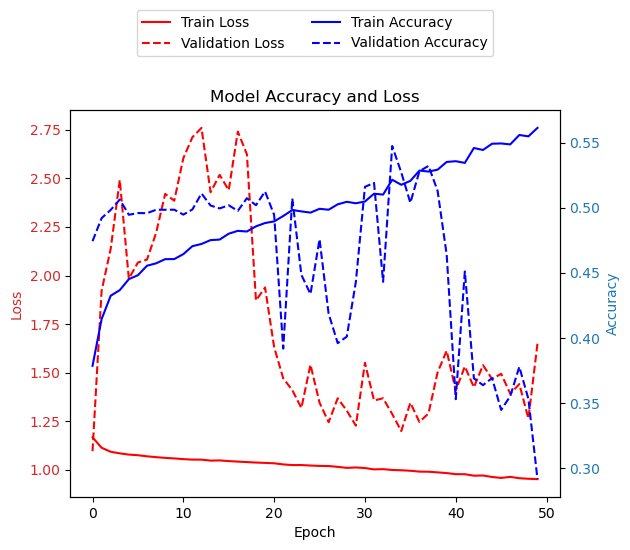

349/349 [==============================] - 3s 8ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 11154, 'input_window': 48, 'output_window': 48, 'outlier_threshold': 0.75, 'accuracy': 0.22628653397884166, 'precision': 0.26098577234985304, 'recall': 0.2252947317110554, 'f1': 0.17028323654631292}
preprocessing...
length of train, valid, test: 
(32888, 96, 8)
(15837, 96, 8)
(10853, 96, 8)
distributions:
borrow_rate_Y_train: [20398  6710  5780]
borrow_rate_Y_valid: [13681  1722   434]
borrow_rate_Y_test: [9614 1106  133]
Training...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 96, 80)            28480     
             

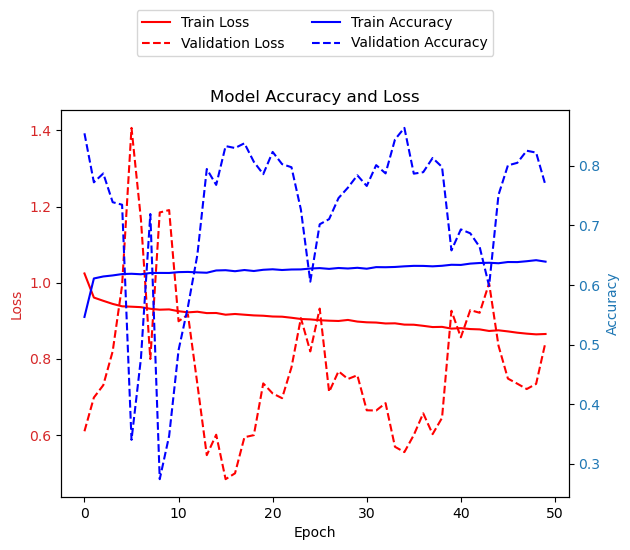

340/340 [==============================] - 5s 13ms/step
{'columns': "['lending_rate', 'borrowing_rate', 'utilization_rate', 'yield', 'market_cap', 'attention', 'returns', 'volume']", 'total_test_windows': 10853, 'input_window': 96, 'output_window': 8, 'outlier_threshold': 0.75, 'accuracy': 0.7589606560398047, 'precision': 0.3440909636570879, 'recall': 0.39023284934706304, 'f1': 0.3348381037419221}


In [30]:
# Trying the 0.75 outlier
outlier_threshold = 0.75
results_arr_9 = []
for comb in input_output_combination: 
    try:
        print('preprocessing...')
        input_window = comb['input'] #***
        output_window = comb['output'] #***

        # Initialize empty lists to store aggregated inputs and targets
        X_train,X_valid,X_test = [], [], []
        Y_train,Y_valid,Y_test = [], [], []
        # looping through symbols
        symbols = filtered_df['crypto_symbol'].unique()
        for s in symbols:
            try:
                sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                sim_df.reset_index(inplace=True, drop=True)
                
                # First Loop: Calculate intervals for each column without modifying the DataFrame
                intervals = {}
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                    intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                    # getting the returns
                reduced_df = sim_df.copy()
                reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                reduced_df = reduced_df[reduced_df['returns'].notna()]
                reduced_df.reset_index(inplace=True, drop=True)

                # Second Loop: Filter rows based on the pre-calculated intervals
                for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                    lower_bound = intervals[column]['lower_bound']
                    upper_bound = intervals[column]['upper_bound']
                    # Apply filtering based on pre-calculated bounds
                    reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                reduced_df.reset_index(inplace=True, drop=True)

                # MinMax scaling
                scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                scaled_df = reduced_df.copy()
                scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(scaled_df,
                'date', input_window, output_window, input_columns, ['lending_rate','borrowing_rate'],train_end_date="2023-05-01 00:00:00", valid_end_date="2023-08-25 00:00:00")

                # Append results from the current DataFrame
                X_train.append(inputs_train)
                X_valid.append(inputs_valid)
                X_test.append(inputs_test)
                Y_train.append(targets_train)
                Y_valid.append(targets_valid)
                Y_test.append(targets_test)

            # Handle any other exceptions
            except Exception as e:
                print(f"Unexpected error in symbol {s}: {e}")

        # Concatenate all inputs and targets into single arrays
        X_train = [arr for arr in X_train if len(arr) > 0]
        X_valid = [arr for arr in X_valid if len(arr) > 0]
        X_test = [arr for arr in X_test if len(arr) > 0]

        Y_train = [arr for arr in Y_train if len(arr) > 0]
        Y_valid = [arr for arr in Y_valid if len(arr) > 0]
        Y_test = [arr for arr in Y_test if len(arr) > 0]

        X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
        X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
        X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

        Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
        Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
        Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])
        # Lending rate
        lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
        lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
        lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
        # Borrowing rate
        borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
        borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
        borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

        print('length of train, valid, test: ')
        print(X_train.shape)
        print(X_valid.shape)
        print(X_test.shape)

        print("distributions:")
        print('borrow_rate_Y_train:', np.bincount(borrow_rate_Y_train.flatten()))
        print('borrow_rate_Y_valid:',np.bincount(borrow_rate_Y_valid.flatten()))
        print('borrow_rate_Y_test:',np.bincount(borrow_rate_Y_test.flatten()))

        print('Training...')
        Y_test, y_pred = pre.train_v2(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test, details=True,epochs=epoch_num, batch_size=bacth_size)
        
        accuracy, precision, recall, f1 = pre.classification_metrics(Y_test, y_pred, printed = False)

        total_windows = Y_test.shape[0]
            
        new_row = {
            'columns': f'{input_columns}',
            'total_test_windows':total_windows,
            'input_window':input_window,
            'output_window':output_window, 
            'outlier_threshold':outlier_threshold, 
            'accuracy':accuracy, 
            'precision':precision, 
            'recall':recall, 
            'f1':f1
        }
        results_arr_9.append(new_row)
        print(new_row)
        
    except Exception as e:
        print(f"Error occurred with {input_columns}")
        print(f"Exception details: {e}")

results = pd.DataFrame(results_arr_9)


In [31]:
results.to_csv('0.75_outlier_v2.csv')
results

,columns,total_test_windows,input_window,output_window,outlier_threshold,accuracy,precision,recall,f1
0,"['lending_rate', 'borrowing_rate', 'utilizatio...",11154,48,48,0.75,0.226287,0.260986,0.225295,0.170283
1,"['lending_rate', 'borrowing_rate', 'utilizatio...",10853,96,8,0.75,0.758961,0.344091,0.390233,0.334838


### Also tightening threshold value was not helpful.

### What is obvious from the graph is that we are facing an overfitting problem that we may be able to solve with simpler architecture or changing the dropouts.

### End of Notebook